# <center>Dominos - Predictive Purchase Order System

**Problem Statement:**
Dominos wants to optimize the process of ordering ingredients by predicting future sales and creating a purchase order. By accurately forecasting sales, Dominos can ensure that it has the right amount of ingredients in stock, minimizing waste and preventing stockouts. This project aims to leverage historical sales data and ingredient information to develop a predictive model and generate an efficient purchase order system.

**Business Use Cases:**
Inventory Management: Ensuring optimal stock levels to meet future demand without overstocking.
Cost Reduction: Minimizing waste and reducing costs associated with expired or excess inventory.
Sales Forecasting: Accurately predicting sales trends to inform business strategies and promotions.
Supply Chain Optimization: Streamlining the ordering process to align with predicted sales and avoid disruptions.



# Imports and Pre-Requisites

In [73]:
# pip install numpy matplotlib pmdarima scikit-learn pandas prophet xgboost seaborn xlsxwriter

Use below versions of prophet, if faced with default versions of prophet

In [74]:
# !pip uninstall holidays prophet pystan
# !pip install holidays==0.19.0
# !pip install prophet==1.1.2

Imports

In [75]:
# Data handling and manipulation
import numpy as np
import pandas as pd
import logging

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import Prediction_Methods as mp
from IPython.display import Markdown

connverting CSV to dataframes using pandas

In [76]:
df_ing = pd.read_csv("datasets/pizza_ingredients.csv")
df_sales = pd.read_csv("datasets/pizza_sales.csv")

# Pre-Processing Pizza Ingredients Data

In [77]:
df_ing.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [78]:
df_ing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


Extracting Strings from categorical columns

In [79]:
df_ing['pizza_name'] = df_ing['pizza_name'].str.replace(r'[^a-zA-Z0-9 ]', '')
df_ing['pizza_ingredients'] = df_ing['pizza_ingredients'].str.replace(r'[^a-zA-Z0-9 ]', '')

# Filling null values in pizza ingredients dataset with similar category

In [80]:
df_ing.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

Checking null value columns

In [81]:
null_counts = df_ing.groupby('pizza_ingredients')['Items_Qty_In_Grams'].apply(lambda x: x.isnull().sum())
null_counts_greater_than_zero = null_counts[null_counts > 0]
print(f"Null values by {null_counts_greater_than_zero}")

Null values by pizza_ingredients
Caramelized Onions    1
Sliced Ham            3
Name: Items_Qty_In_Grams, dtype: int64


Mean and Median of Item_Qty_In_Grams column

In [82]:
print("Average of Items_Qty_In_Grams",round(df_ing['Items_Qty_In_Grams'].mean()))
median = df_ing['Items_Qty_In_Grams'].median()
print("Median of Items_Qty_In_Grams",median)

Average of Items_Qty_In_Grams 31
Median of Items_Qty_In_Grams 20.0


Filling Caramelized Onions null values with median of Items_Qty_In_Grams column

In [83]:
df_ing.loc[df_ing['pizza_ingredients'] == 'Caramelized Onions', 
           'Items_Qty_In_Grams'] = df_ing.loc[df_ing['pizza_ingredients'] == 'Caramelized Onions', 'Items_Qty_In_Grams'].fillna(value=median)

Finding Similar category Beef and Chicken for filling null values of Sliced Ham

In [84]:
# Category that has ingredients of Beef
filtered_df = df_ing[df_ing['pizza_ingredients'].str.contains('Beef', na=False)]
print(filtered_df[['pizza_name_id', 'Items_Qty_In_Grams']])

     pizza_name_id  Items_Qty_In_Grams
468    the_greek_l               100.0
474    the_greek_m                70.0
480    the_greek_s                50.0
486   the_greek_xl               150.0
492  the_greek_xxl               200.0


In [85]:
# Category that has ingredients of Chicken
filtered_df = df_ing[df_ing['pizza_ingredients'].str.contains('Chicken', na=False)]
print(filtered_df[['pizza_name_id', 'Items_Qty_In_Grams']])

     pizza_name_id  Items_Qty_In_Grams
0        bbq_ckn_l                40.0
6        bbq_ckn_m                30.0
12       bbq_ckn_s                20.0
46      cali_ckn_l               150.0
53      cali_ckn_m               100.0
60      cali_ckn_s                50.0
67   ckn_alfredo_l               150.0
73   ckn_alfredo_m               100.0
79   ckn_alfredo_s                50.0
85     ckn_pesto_l               150.0
91     ckn_pesto_m               100.0
97     ckn_pesto_s                50.0
350   southw_ckn_l               150.0
358   southw_ckn_m               100.0
366   southw_ckn_s                50.0
449     thai_ckn_l               150.0
454     thai_ckn_m               100.0
459     thai_ckn_s                50.0


In [86]:
filtered_df = df_ing[df_ing['pizza_ingredients'].str.contains('Ham', na=False)]
print(filtered_df[['pizza_name_id', 'Items_Qty_In_Grams']])

    pizza_name_id  Items_Qty_In_Grams
149    hawaiian_l                 NaN
152    hawaiian_m                 NaN
155    hawaiian_s                 NaN


Filling Sliced Ham null values with similar category pizza - the_greek_l, the_greek_m, the_greek_s(Beef Ingredient)

In [87]:
pizza_id = {"_s":50, "_m":70, "_l":100}

for size_key, qty in pizza_id.items():
    df_ing.loc[
        (df_ing['pizza_ingredients'] == 'Sliced Ham') & 
        (df_ing['pizza_name_id'].str.contains(size_key)) & 
        (df_ing['Items_Qty_In_Grams'].isnull()), 
        'Items_Qty_In_Grams'
    ] = qty

No null values now!!

In [88]:
df_ing.isna().sum().sum()

0

Converting object columns to category

In [89]:
df_ing[df_ing.select_dtypes(include=['object']).columns] = df_ing.select_dtypes(include=['object']).apply(lambda x: x.astype('category'))
df_ing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   pizza_name_id       518 non-null    category
 1   pizza_name          518 non-null    category
 2   pizza_ingredients   518 non-null    category
 3   Items_Qty_In_Grams  518 non-null    float64 
dtypes: category(3), float64(1)
memory usage: 12.3 KB


# Pre-Processing Pizza Sales Data

In [90]:
df_sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [91]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


Checking column that is having null values

In [92]:
df_sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

Converting Date time and time columns

In [93]:
df_sales['order_date'] = df_sales['order_date'].str.replace('/', '-')
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'], dayfirst=True)
df_sales['order_time'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S').dt.time

# Imputing null values for pizza sales data with Random Forest method

In [94]:
# Imputing null values for Pizza Category column with similar column pizza_name_id
df_sales = mp.impute_values(df=df_sales, target='pizza_category',feature_columns=['pizza_name_id'], isna=True)

# Imputing null values for Pizza Name column with similar column pizza_ingredients
df_sales = mp.impute_values(df=df_sales, target='pizza_name',feature_columns=['pizza_ingredients'], isna=True)

# Imputing null values for Pizza Ingredients column with similar columns pizza_name and pizza_category
df_sales = mp.impute_values(df=df_sales, target='pizza_ingredients',feature_columns=['pizza_name', 'pizza_category'])

# Imputing null values for Pizza Name Id column with similar column pizza_name, pizza_category, pizza_ingredients, pizza_size
df_sales = mp.impute_values(df=df_sales, target='pizza_name_id',feature_columns=['pizza_name', 'pizza_category', 'pizza_ingredients', 'pizza_size'])


# Filling null values in 'total_price' with quantity * unit_price
df_sales['total_price'] = df_sales['total_price'].fillna(df_sales['quantity'] * df_sales['unit_price'])

Model f1 score for pizza_category imputation: 1.00
Model f1 score for pizza_name imputation: 1.00
Model f1 score for pizza_ingredients imputation: 1.00
Model f1 score for pizza_name_id imputation: 1.00


No null values now!!

In [95]:
df_sales.isna().sum().sum()

0

Extracting Strings from categorical columns

In [96]:
df_sales['pizza_ingredients'] = df_sales['pizza_ingredients'].str.replace(r'[\w\s,]+', '')
df_sales['pizza_name'] = df_sales['pizza_name'].str.replace(r'[\w\s,]+', '')

Converting object columns to category

In [97]:
object_cols = df_sales.select_dtypes(include=['object']).columns
object_cols = object_cols[object_cols != 'order_time']

# Convert the remaining object columns to category
df_sales[object_cols] = df_sales[object_cols].apply(lambda x: x.astype('category'))

In [98]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_name_id      48620 non-null  category      
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  category      
 9   pizza_category     48620 non-null  category      
 10  pizza_ingredients  48620 non-null  category      
 11  pizza_name         48620 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 2.8+ MB


# EDA

Heatmap of numeric columns in sales data

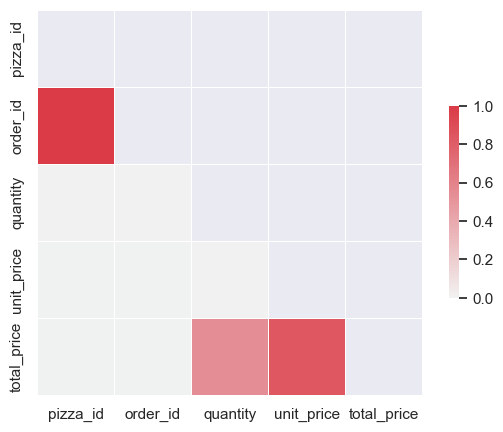

In [99]:
df_sales_numeric = df_sales.select_dtypes(include=[np.number])

sns.set_theme(style='dark')

# Calculate the correlation matrix
corr = df_sales_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

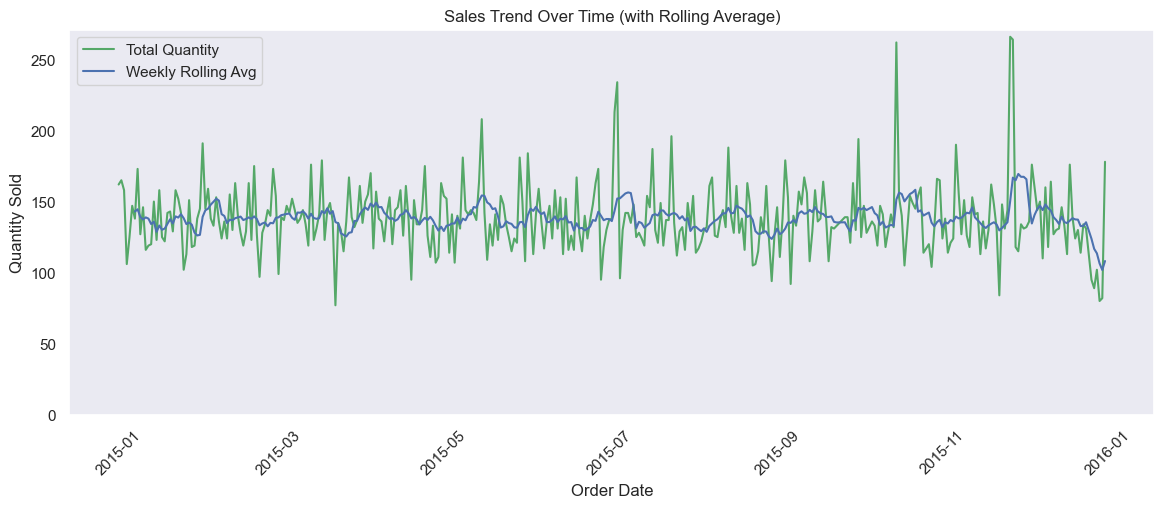

In [100]:
# Convert 'order_date' to datetime format (only if needed)
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])

# Group data to get the total quantity sold for each order_date
df_grouped = df_sales.groupby('order_date', as_index=False).agg({'quantity': 'sum'})

# Create a 7-day rolling average of quantity
df_grouped['rolling_avg'] = df_grouped['quantity'].rolling(window=7).mean()

plt.figure(figsize=(14, 5))

# Plot the total quantity
sns.lineplot(data=df_grouped, x='order_date', y='quantity', color='g', label='Total Quantity')

# Plot the rolling average
sns.lineplot(data=df_grouped, x='order_date', y='rolling_avg', color='b', label='Weekly Rolling Avg')

plt.title('Sales Trend Over Time (with Rolling Average)')
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, df_grouped['quantity'].max() + 5)  # Adjust y-axis to give some buffer
plt.show()


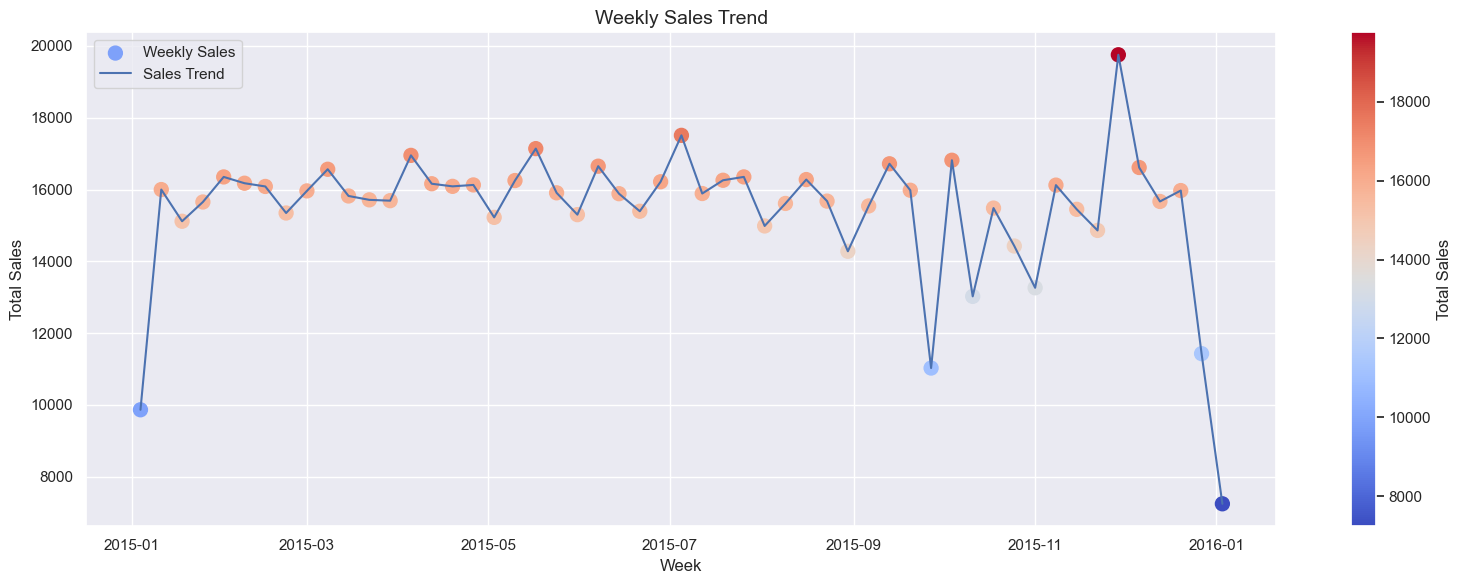

In [101]:
# Group by week to calculate weekly total sales and order count
weekly_metrics = df_sales.resample('W', on='order_date').agg(
    total_sales=('total_price', 'sum'),
    order_count=('pizza_id', 'count')  
).reset_index()

plt.figure(figsize=(16, 6))
plt.scatter(weekly_metrics['order_date'], weekly_metrics['total_sales'], 
            c=weekly_metrics['total_sales'], cmap='coolwarm', s=100, label='Weekly Sales')
plt.plot(weekly_metrics['order_date'], weekly_metrics['total_sales'], color='b', label='Sales Trend')
plt.title('Weekly Sales Trend', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True)
plt.legend()
plt.colorbar(label='Total Sales')
plt.tight_layout()
plt.show()


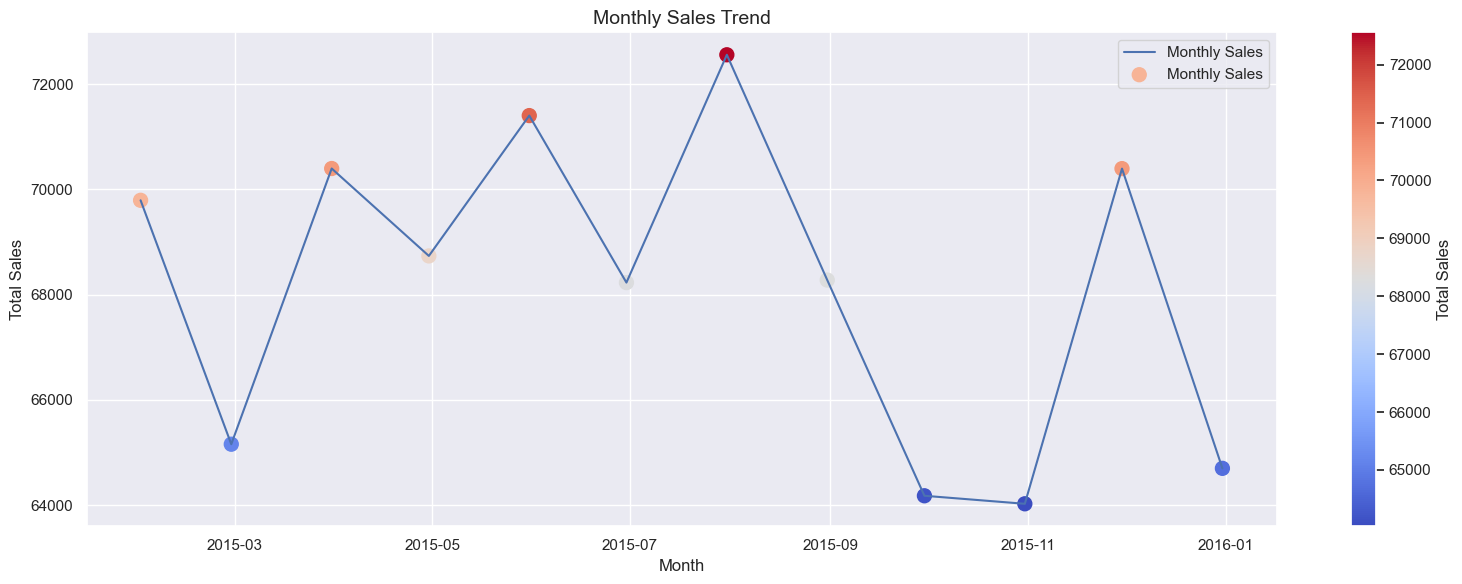

In [102]:
# Group by month to calculate monthly total sales and order count
monthly_metrics = df_sales.resample('ME', on='order_date').agg(
    total_sales=('total_price', 'sum'),
    order_count=('pizza_id', 'count') 
).reset_index()

plt.figure(figsize=(16, 6))
plt.plot(monthly_metrics['order_date'], monthly_metrics['total_sales'], color='b', label='Monthly Sales')
plt.scatter(monthly_metrics['order_date'], monthly_metrics['total_sales'], 
            c=monthly_metrics['total_sales'], cmap='coolwarm', s=100, label='Monthly Sales')
plt.title('Monthly Sales Trend', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True)
plt.legend()
plt.colorbar(label='Total Sales')
plt.tight_layout()
plt.show()


2024-12-13 00:28:53,539 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-13 00:28:53,539 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


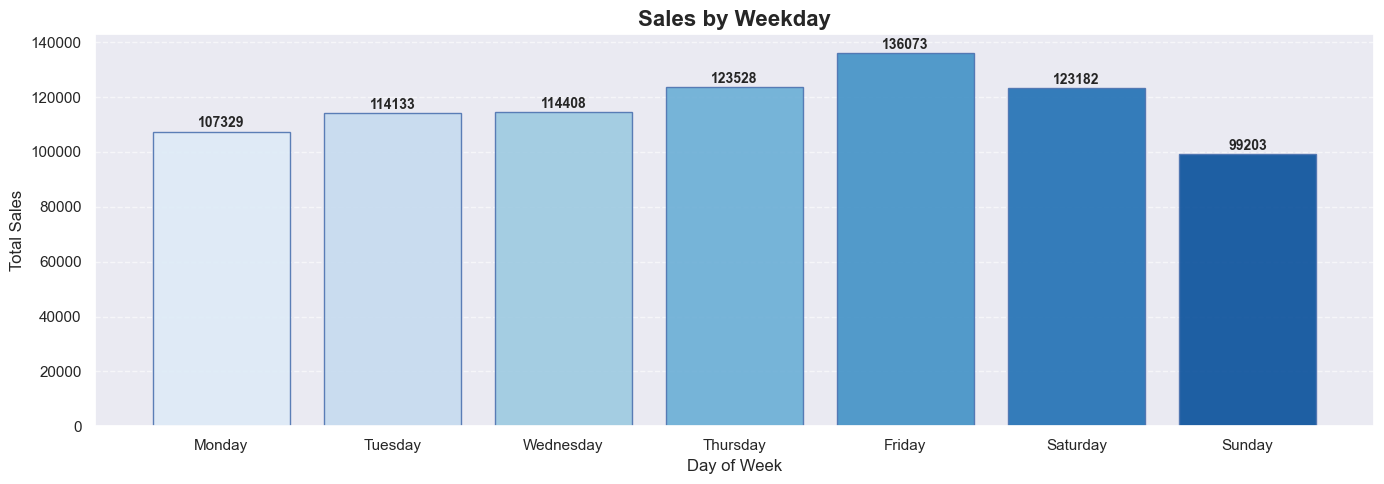

In [103]:
# Extract weekday number and name
df_sales['weekday_num'] = df_sales['order_date'].dt.weekday  # 0=Monday, 6=Sunday
df_sales['weekday_name'] = df_sales['order_date'].dt.day_name()

# Group by weekday number to calculate total sales and order count
weekday_metrics = df_sales.groupby(['weekday_num', 'weekday_name']).agg(
    total_sales=('total_price', 'sum'),
    order_count=('pizza_id', 'count')
).reset_index()

# Create a gradient color palette for the bars
bar_colors = sns.color_palette("Blues", len(weekday_metrics))  # Gradient of Blues

# Plot the bar chart
plt.figure(figsize=(14, 5))
bars = plt.bar(weekday_metrics['weekday_name'], 
               weekday_metrics['total_sales'], 
               color=bar_colors, 
               edgecolor='b', 
               alpha=0.9)

plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.title('Sales by Weekday', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 500, 
             f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


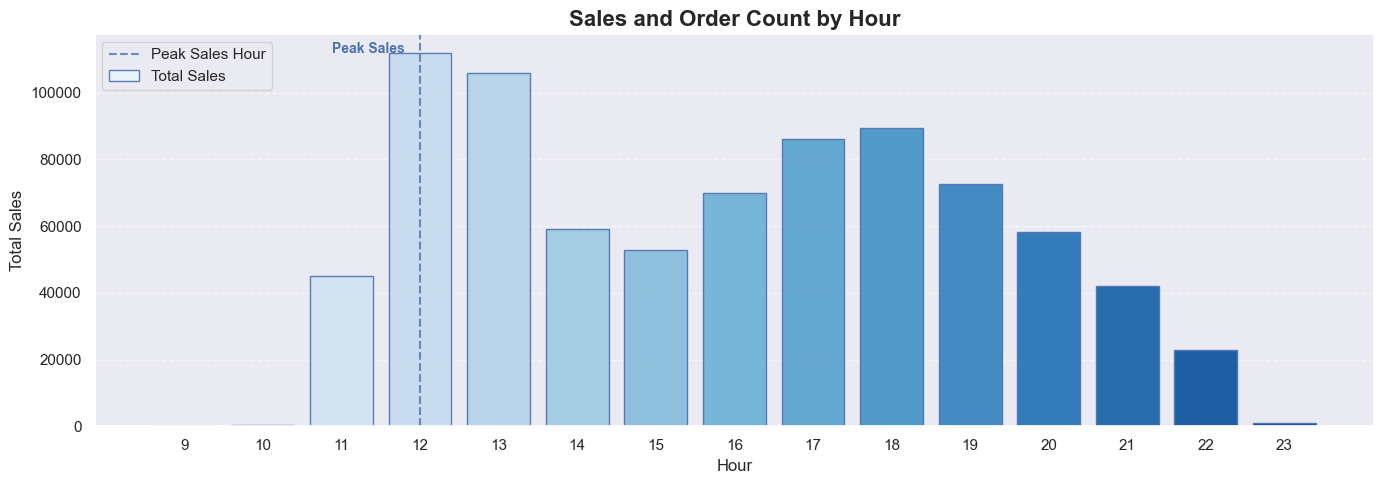

In [104]:
df_sales['order_time'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S', errors='coerce')
df_sales['hour'] = df_sales['order_time'].dt.hour 

# Group by hour to calculate total sales and order count
weekday_metrics = df_sales.groupby(['hour']).agg(
    total_sales=('total_price', 'sum'),
    order_count=('pizza_id', 'count')
).reset_index()

# Sort by hour (ensure it's numeric)
hour_metrics = weekday_metrics.sort_values('hour', ascending=True)

# Create a gradient color palette for the bars
bar_colors = sns.color_palette("Blues", len(hour_metrics))  # Gradient of Blues

# Plot hourly trends for total sales and order count
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot total sales as bar plot with gradient color
bars = ax1.bar(hour_metrics['hour'], 
               hour_metrics['total_sales'], 
               color=bar_colors, 
               edgecolor='b', 
               alpha=0.9, 
               label='Total Sales')

# Highlight peak hour for total sales
peak_sales_hour = hour_metrics.loc[hour_metrics['total_sales'].idxmax(), 'hour']
ax1.axvline(x=peak_sales_hour, color='b', linestyle='--', alpha=0.8, label='Peak Sales Hour')

# Annotate peak sales hour
peak_sales = hour_metrics['total_sales'].max()
ax1.text(peak_sales_hour, peak_sales, 'Peak Sales    ', 
         color='b', fontsize=10, fontweight='bold', ha='right')

# Customize axes, labels, and grid
ax1.set_ylabel('Total Sales', fontsize=12)
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_xticks(hour_metrics['hour'])
ax1.set_xticklabels(hour_metrics['hour'])
ax1.set_title('Sales and Order Count by Hour', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.legend(loc='upper left')

# Highlight peak order count hour
peak_order_hour = hour_metrics.loc[hour_metrics['order_count'].idxmax(), 'hour']

# Annotate peak order count hour
peak_orders = hour_metrics['order_count'].max()
# Final layout adjustments
plt.tight_layout()
plt.show()

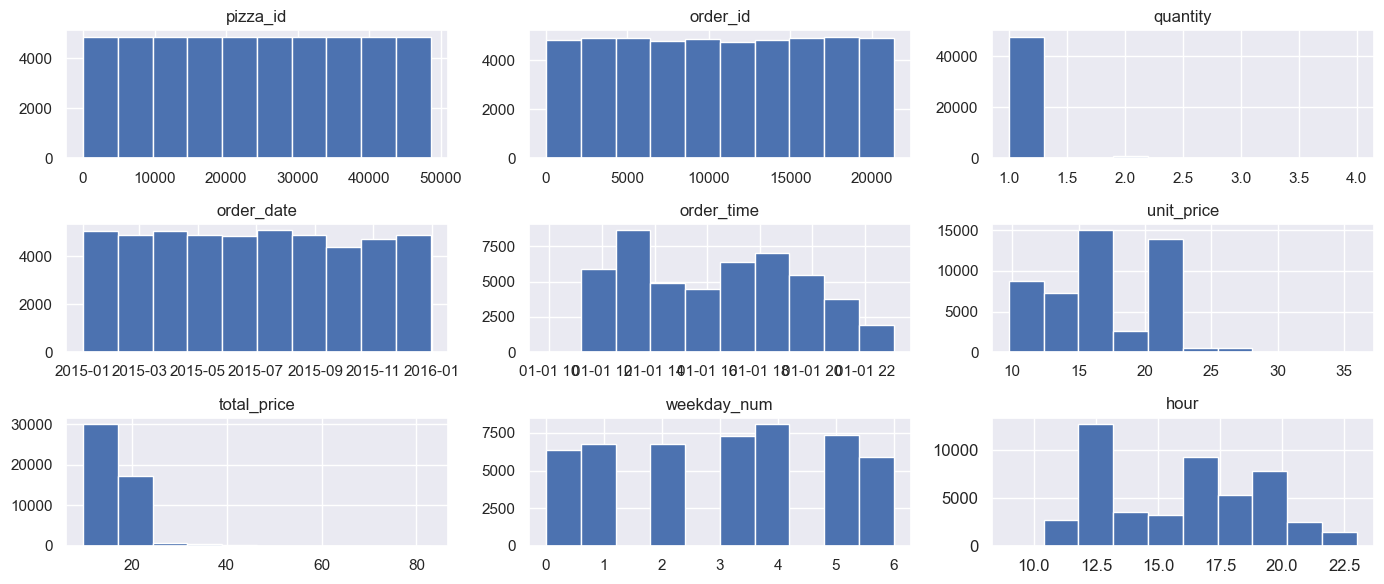

In [105]:
df_sales.hist(figsize=(14,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

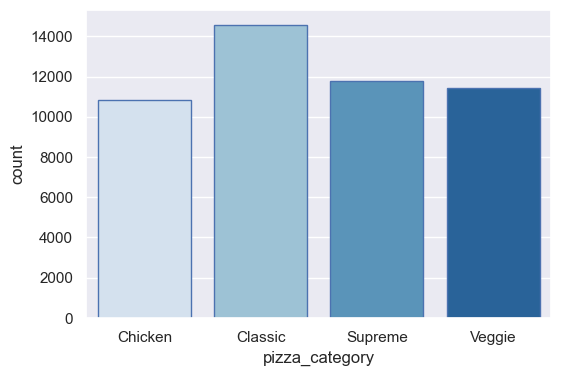

In [106]:
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
sns.countplot(x='pizza_category', hue='pizza_category',palette='Blues', edgecolor='b', data=df_sales)
plt.show()

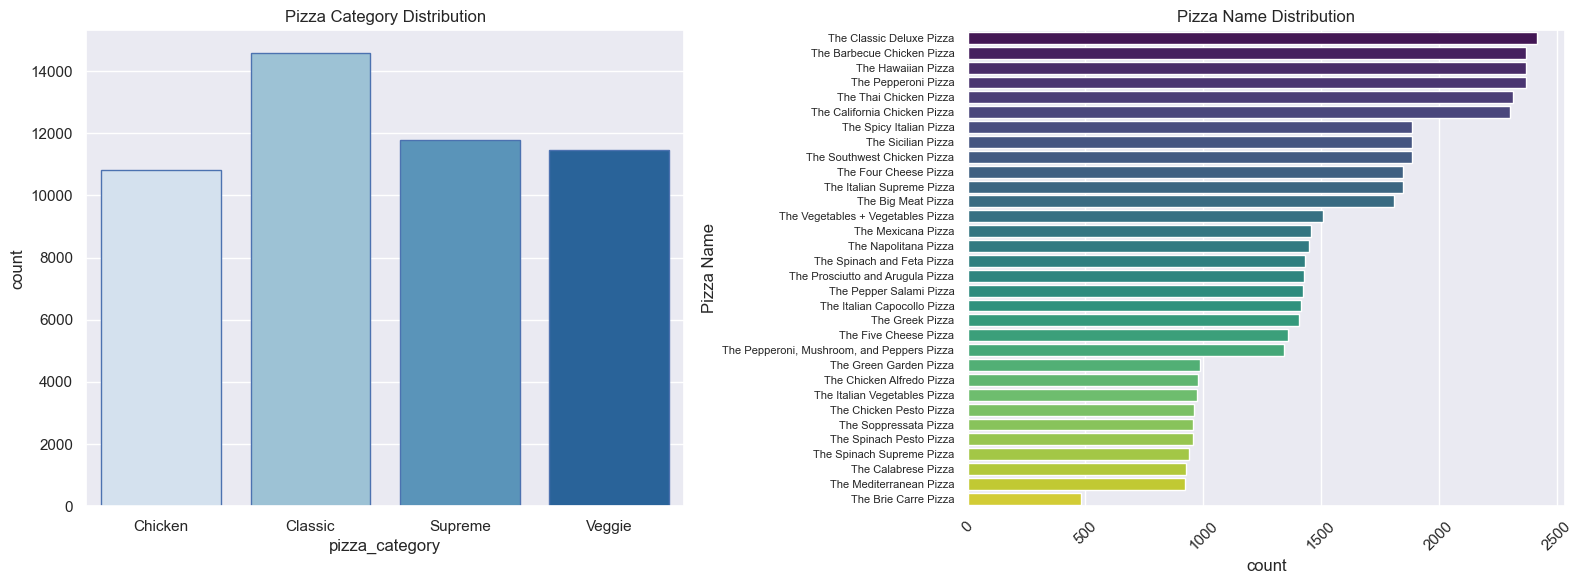

In [107]:
# Order pizza names by count and get the ordered categories
pizza_name_order = df_sales['pizza_name'].value_counts().index
# dictionary mapping pizza names to colors
palette = sns.color_palette("viridis", len(pizza_name_order))
color_dict = {name: palette[i] for i, name in enumerate(pizza_name_order)}
# Set the style
sns.set_style('darkgrid')

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for pizza category
sns.countplot(x='pizza_category', hue='pizza_category',palette='Blues', edgecolor='b', data=df_sales, ax=axes[0])
axes[0].set_title('Pizza Category Distribution')

# Plot for pizza names (with rotated labels and horizontal bars for better readability)
sns.countplot(y='pizza_name', hue='pizza_name', color='w', data=df_sales, ax=axes[1], order=pizza_name_order, palette=color_dict)
axes[1].set_title('Pizza Name Distribution')
axes[1].tick_params(axis='y', labelsize=8)  # Reduce font size for y-axis labels
axes[1].set_ylabel('Pizza Name')

# Rotate labels on the x-axis for better readability
for label in axes[1].get_xticklabels():
    label.set_rotation(45)

# Show the plots
plt.tight_layout()
plt.show()


Outlier Detection

In [108]:
df_sales.describe()

,pizza_id,order_id,quantity,order_date,order_time,unit_price,total_price,weekday_num,hour
count,48620.000000,48620.000000,48620.000000,48620,48620,48620.000000,48620.000000,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,2015-06-29 11:03:43.611682560,1900-01-01 16:24:51.322151424,16.494132,16.821474,3.023797,15.911806
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,1900-01-01 09:52:21,9.750000,9.750000,0.000000,9.000000
25%,12155.750000,5337.000000,1.000000,2015-03-31 00:00:00,1900-01-01 13:24:46,12.750000,12.750000,1.000000,13.000000
50%,24310.500000,10682.500000,1.000000,2015-06-28 00:00:00,1900-01-01 16:33:33,16.500000,16.500000,3.000000,16.000000
75%,36465.250000,16100.000000,1.000000,2015-09-28 00:00:00,1900-01-01 18:55:19,20.250000,20.500000,5.000000,18.000000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,1900-01-01 23:05:52,35.950000,83.000000,6.000000,23.000000
std,14035.529381,6180.119770,0.143077,NaN,NaN,3.621789,4.437398,1.934155,3.149836


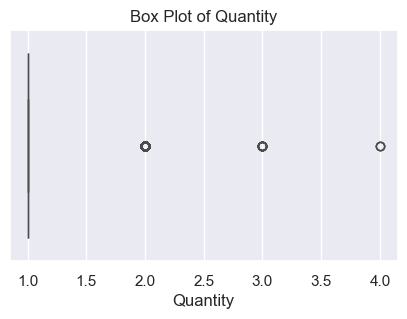

In [109]:
plt.figure(figsize=(5, 3))
sns.boxplot(x=df_sales['quantity'])
plt.title('Box Plot of Quantity')
plt.xlabel('Quantity')
plt.show()

Count and proportion of quantity

In [110]:
counts = df_sales['quantity'].value_counts()
percentages = df_sales['quantity'].value_counts(normalize=True).mul(100).round(1)
result = pd.concat([counts, percentages], axis=1)
result

,count,proportion
quantity,,
1,47693,98.1
2,903,1.9
3,21,0.0
4,3,0.0


As we have very less percentage for 3 and 4 we can change 3 and 4 values to 2. using clipp in np for this

In [111]:
# Cap the quantity values at 2
df_sales['quantity'] = np.clip(df_sales['quantity'], 1, 2)

# Model Selection

In [112]:
df_sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,weekday_num,weekday_name,hour
0,1,1,hawaiian_m,1,2015-01-01,1900-01-01 11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,3,Thursday,11
1,2,2,classic_dlx_m,1,2015-01-01,1900-01-01 11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,3,Thursday,11
2,3,2,five_cheese_l,1,2015-01-01,1900-01-01 11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,3,Thursday,11
3,4,2,ital_supr_l,1,2015-01-01,1900-01-01 11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,3,Thursday,11
4,5,2,mexicana_m,1,2015-01-01,1900-01-01 11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,3,Thursday,11


In [113]:
df_sales['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1365
five_cheese_l     1359
four_cheese_l     1273
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

Trying with different values of pizza_name_id, which has high data, medium and very low data for selecting the model<br><br>
Model Used for Predictions are SARIMA, PROPHET, XGBoost

2024-12-13 00:28:55,940 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Validating models for: big_meat_s

Prophet Errors:
MAE: 1.7121212121212122
MSE: 4.590909090909091
RMSE: 2.1426406817077592
MAPE: 0.364146880055971
R2: 0.03614806246385194

SARIMA Errors:
MAE: 1.8636363636363635
MSE: 5.863636363636363
RMSE: 2.421494654884946
MAPE: 0.37122523940705765
R2: -0.23105841526894144

XGBoost Errors:
MAE: 1.7272727489471436
MSE: 4.78787899017334
RMSE: 2.188122252108721
MAPE: 0.37854188680648804
R2: -0.005205392837524414


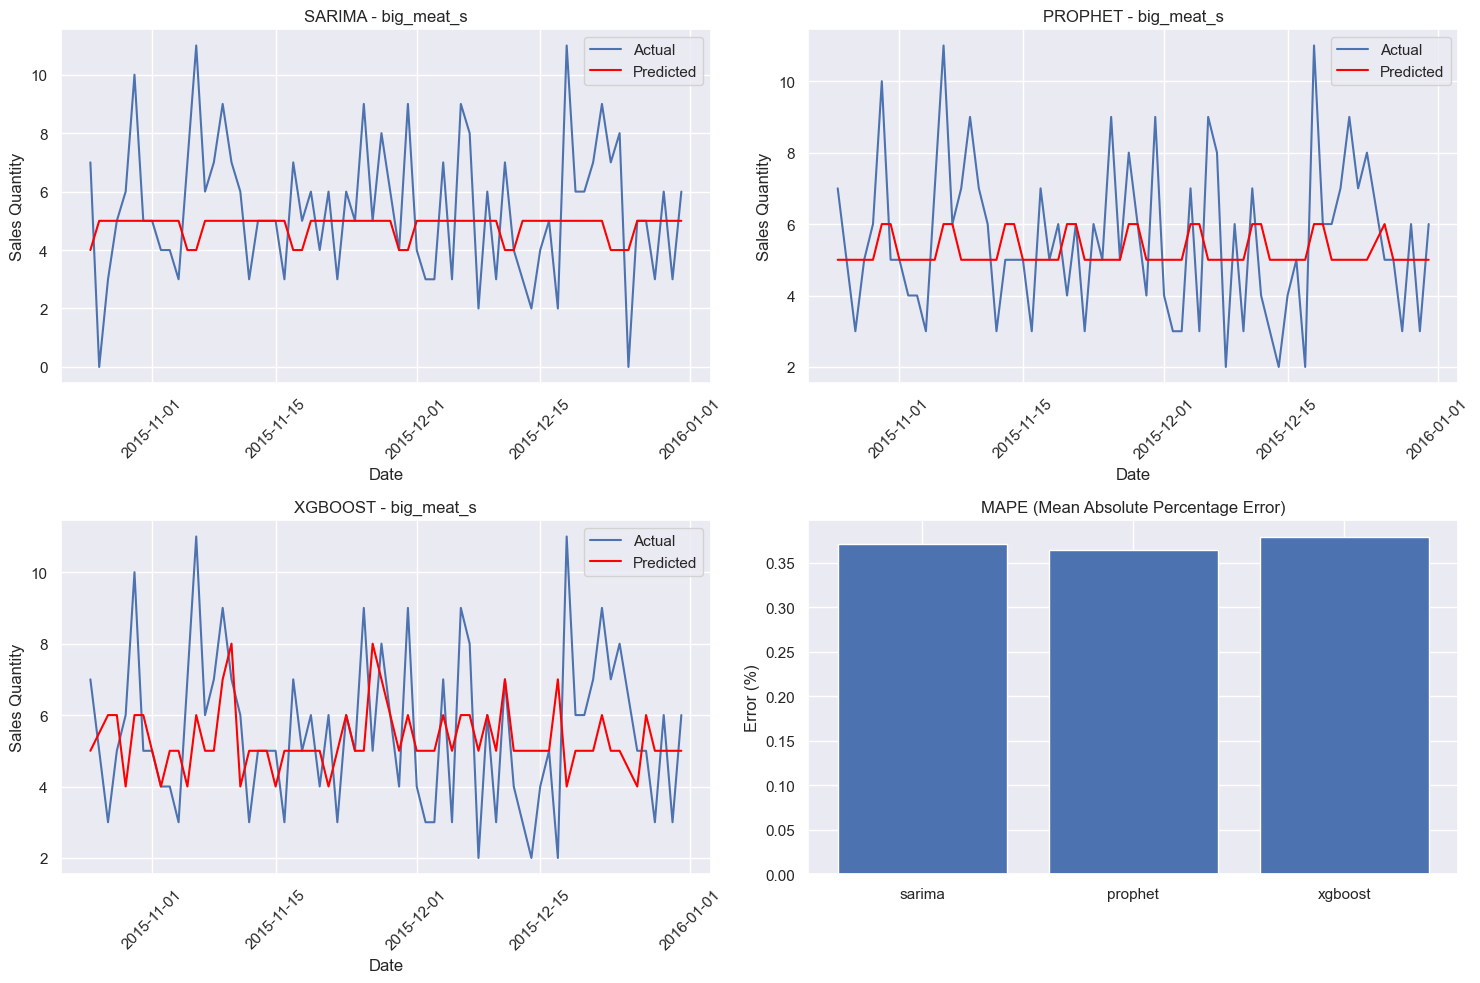

2024-12-13 00:28:57,324 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Validating models for: five_cheese_l

Prophet Errors:
MAE: 1.3492063492063493
MSE: 3.507936507936508
RMSE: 1.872948613266394
MAPE: 0.600453514739229
R2: 0.0463698630136985

SARIMA Errors:
MAE: 1.3333333333333333
MSE: 3.9365079365079363
RMSE: 1.9840634910475865
MAPE: 0.5543083900226757
R2: -0.07013698630136989

XGBoost Errors:
MAE: 1.6031745672225952
MSE: 4.492063522338867
RMSE: 2.1194488723106457
MAPE: 0.6723734140396118
R2: -0.22116422653198242


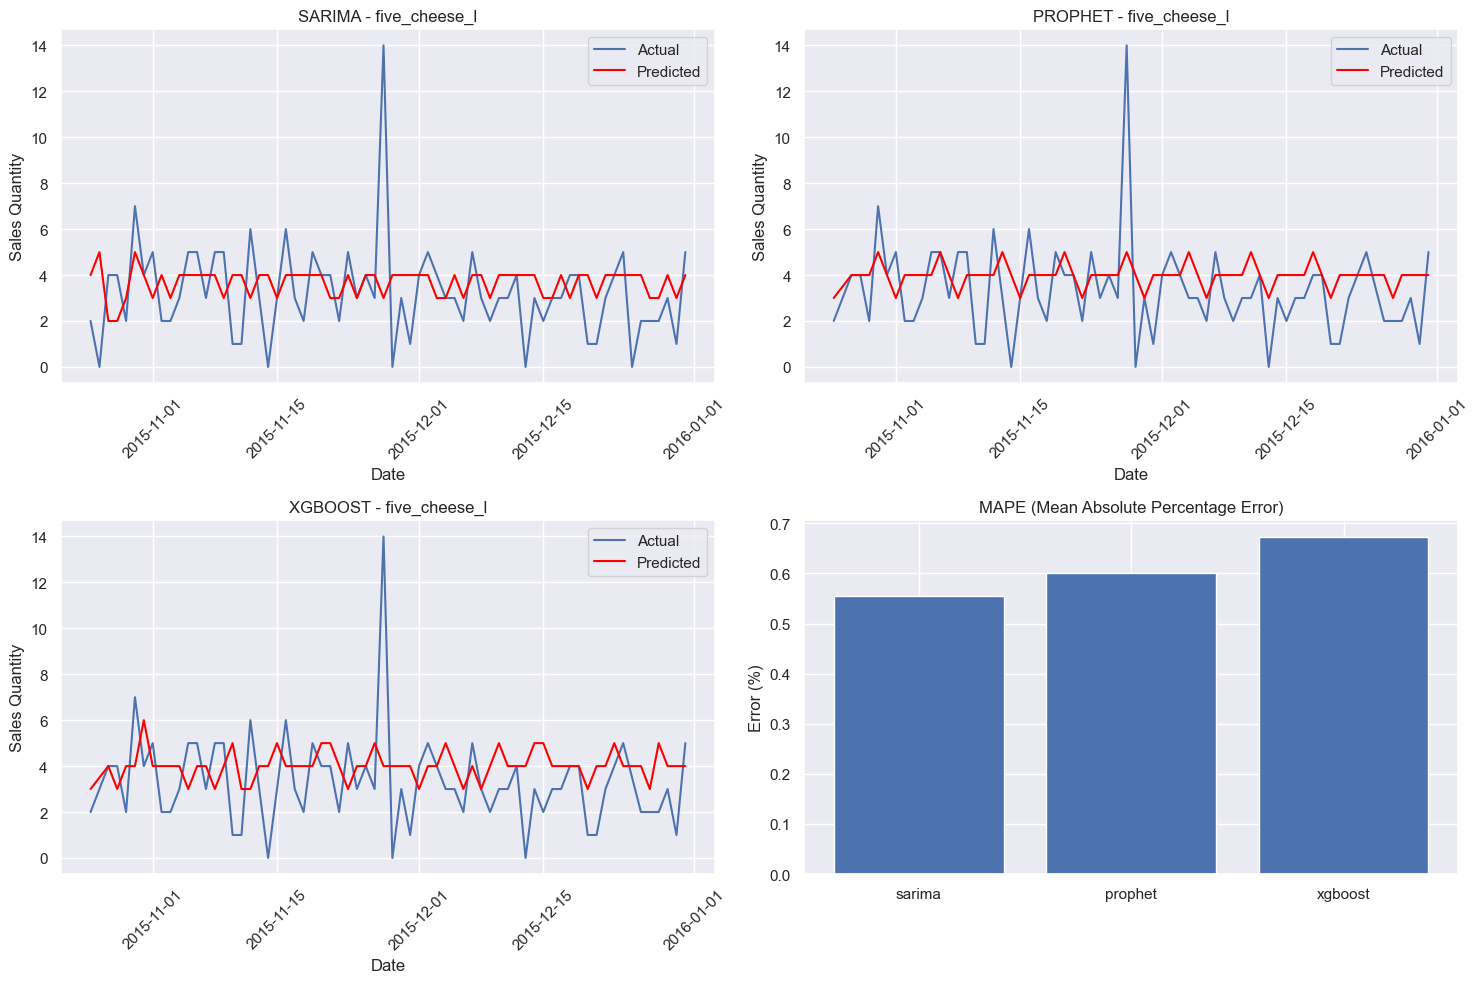

2024-12-13 00:28:58,663 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Validating models for: the_greek_xxl

Prophet Errors:
MAE: 1.0
MSE: 1.0
RMSE: 1.0
MAPE: 1.0
R2: 0.0

SARIMA Errors:
MAE: 1.0
MSE: 1.0
RMSE: 1.0
MAPE: 1.0
R2: 0.0

XGBoost Errors:
MAE: 1.0
MSE: 1.0
RMSE: 1.0
MAPE: 1.0
R2: 0.0


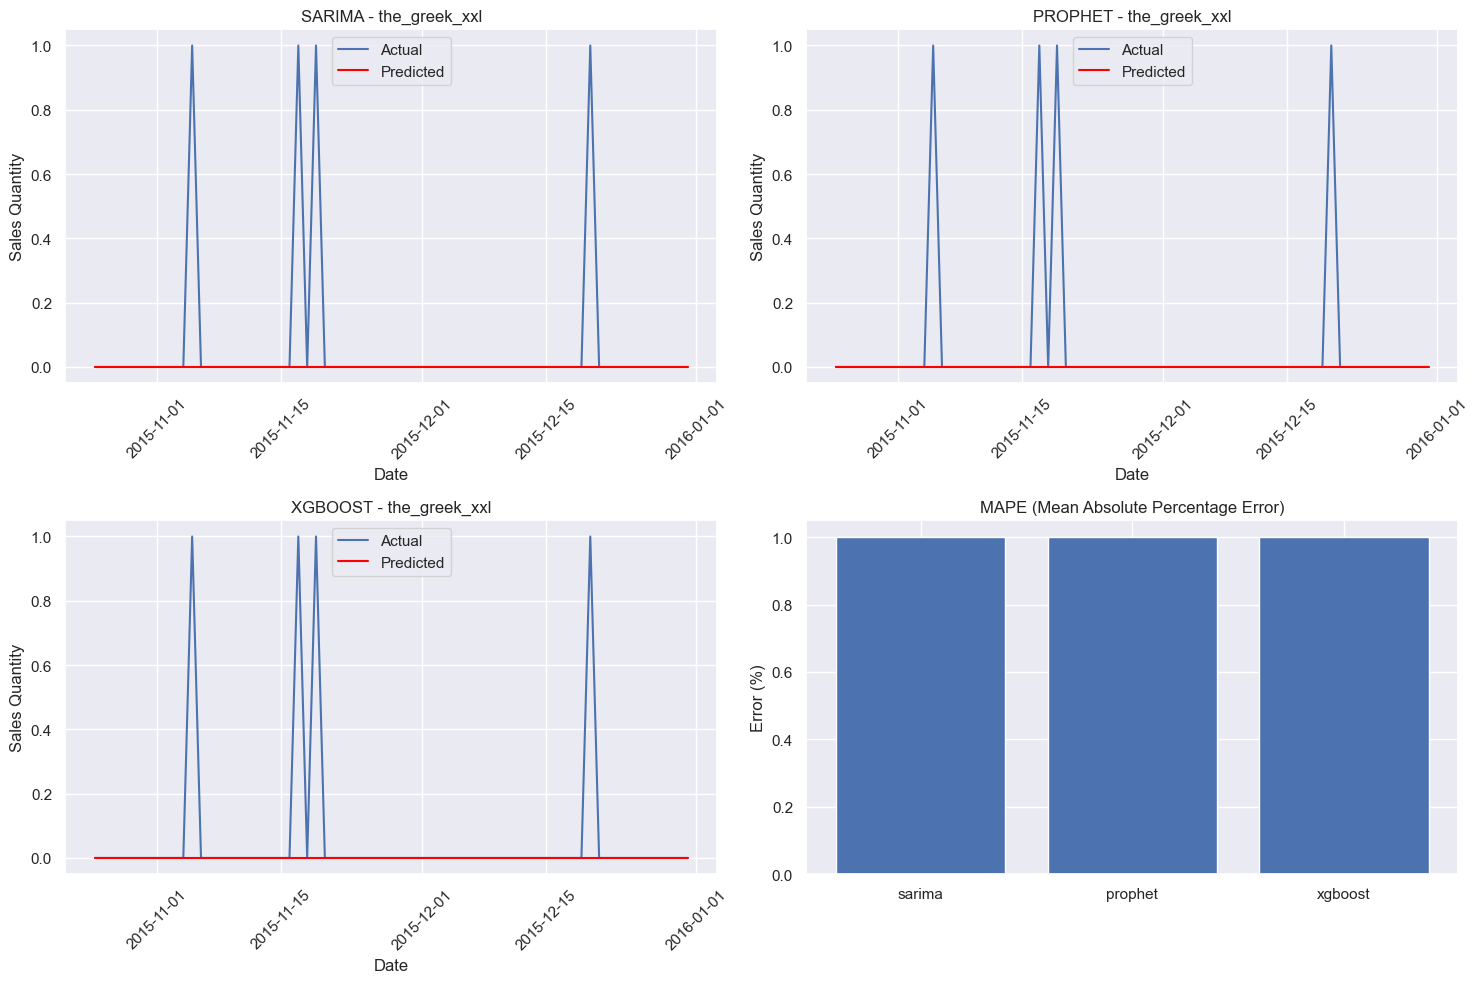

2024-12-13 00:29:00,062 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Validating models for: mexicana_s

Prophet Errors:
MAE: 0.23076923076923078
MSE: 0.3076923076923077
RMSE: 0.5547001962252291
MAPE: 0.10256410256410256
R2: -0.2093023255813955

SARIMA Errors:
MAE: 0.5384615384615384
MSE: 0.8461538461538461
RMSE: 0.9198662110077999
MAPE: 0.35256410256410253
R2: -2.3255813953488373

XGBoost Errors:
MAE: 0.9230769276618958
MSE: 1.1538461446762085
RMSE: 1.074172306790772
MAPE: 0.7692307829856873
R2: -3.534883499145508


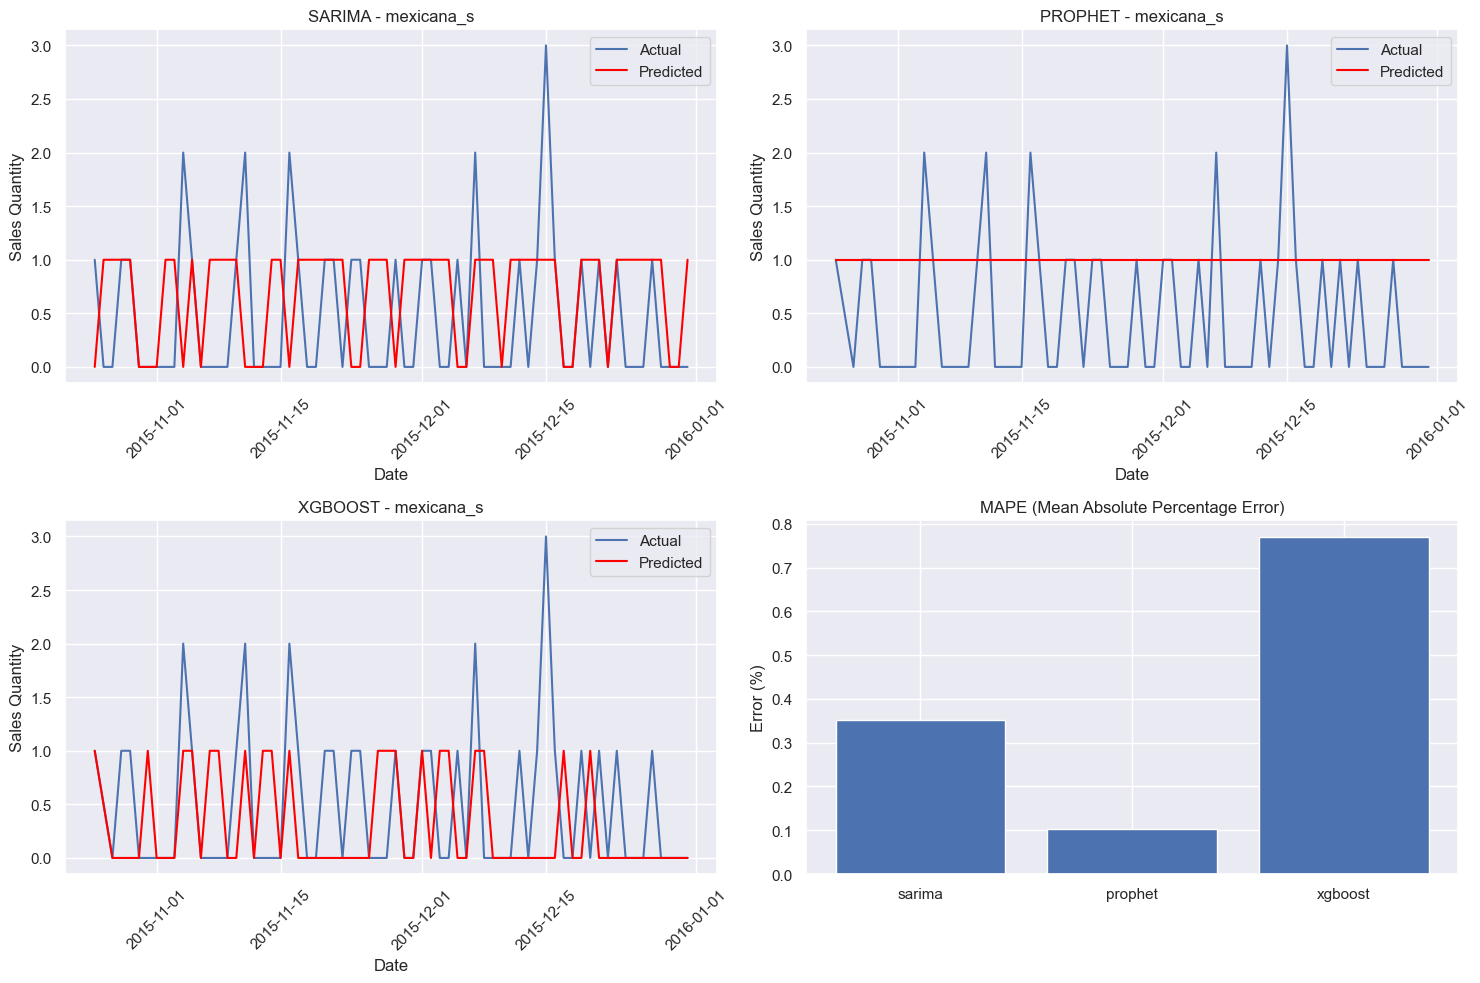


Model Error Comparison:
               prophet_MAPE  sarima_MAPE  xgboost_MAPE
big_meat_s         0.364147     0.371225      0.378542
five_cheese_l      0.600454     0.554308      0.672373
the_greek_xxl      1.000000     1.000000      1.000000
mexicana_s         0.102564     0.352564      0.769231


In [114]:
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
# Load your pizza sales data
df = df_sales.copy()
    
pizza_pivot = pm.prepare_pizza_sales_data(df)
pizza_pivot_with_lags = pm.create_lagged_features(pizza_pivot)

# Initialize model validator
validator = pm.PizzaSalesModelValidator(pizza_pivot_with_lags)

# Split data into train and test
train_data, test_data = validator.train_test_split()

# Select pizza types to validate
pizza_types = ['big_meat_s', 'five_cheese_l', 'the_greek_xxl', 'mexicana_s']

# Validate models for each pizza type
for pizza_name in pizza_types:
    print(f"\nValidating models for: {pizza_name}")
    
    # Validate each model
    prophet_errors = validator.validate_prophet_model(pizza_name)
    sarima_errors = validator.validate_sarima_model(pizza_name)
    xgboost_errors = validator.validate_xgboost_model(pizza_name)
    
    # Print individual model errors
    print("\nProphet Errors:")
    for metric, value in prophet_errors.items():
        print(f"{metric}: {value}")
    
    print("\nSARIMA Errors:")
    for metric, value in sarima_errors.items():
        print(f"{metric}: {value}")
    
    print("\nXGBoost Errors:")
    for metric, value in xgboost_errors.items():
        print(f"{metric}: {value}")
    
    # Plot model comparisons
    validator.plot_model_comparison(pizza_name)

# Compare errors across models
error_comparison = validator.compare_model_errors(pizza_types)
print("\nModel Error Comparison:")
print(error_comparison)

Model not able to predict for pizza that has very less data, also we cannot use only model for predicting all pizza types

So we will be using all three models and storing the best model which has best MAPE score for individual pizza's and predicting individual pizza's based on saved parameter and model.

In [115]:
pizza_cleaned = pm.prepare_pizza_sales_data(df)
pizza_cleaned.columns

Index(['order_date', 'bbq_ckn_l', 'bbq_ckn_m', 'bbq_ckn_s', 'big_meat_s',
       'brie_carre_s', 'calabrese_l', 'calabrese_m', 'calabrese_s',
       'cali_ckn_l', 'cali_ckn_m', 'cali_ckn_s', 'ckn_alfredo_l',
       'ckn_alfredo_m', 'ckn_alfredo_s', 'ckn_pesto_l', 'ckn_pesto_m',
       'ckn_pesto_s', 'classic_dlx_l', 'classic_dlx_m', 'classic_dlx_s',
       'five_cheese_l', 'four_cheese_l', 'four_cheese_m', 'green_garden_l',
       'green_garden_m', 'green_garden_s', 'hawaiian_l', 'hawaiian_m',
       'hawaiian_s', 'ital_cpcllo_l', 'ital_cpcllo_m', 'ital_cpcllo_s',
       'ital_supr_l', 'ital_supr_m', 'ital_supr_s', 'ital_veggie_l',
       'ital_veggie_m', 'ital_veggie_s', 'mediterraneo_l', 'mediterraneo_m',
       'mediterraneo_s', 'mexicana_l', 'mexicana_m', 'mexicana_s',
       'napolitana_l', 'napolitana_m', 'napolitana_s', 'pep_msh_pep_l',
       'pep_msh_pep_m', 'pep_msh_pep_s', 'pepperoni_l', 'pepperoni_m',
       'pepperoni_s', 'peppr_salami_l', 'peppr_salami_m', 'peppr_salami_s

AutomatedPizzaSalesModelSelector Class created for checking models with different parameters and storing the best model as dict, you can view the class in prediction_methods.py file

In [116]:
# Suppress all logs from cmdstanpy
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

model_selector = pm.AutomatedPizzaSalesModelSelector(pizza_cleaned)
best_models = model_selector.select_models_for_all_pizzas()

Best models with best MAPE scores

In [117]:
for model in best_models:
    print(f"Pizza id : {model}, Best Model : {best_models[model]['model_type']}, Best MAPE Score: {best_models[model]['mape']}")

Pizza id : bbq_ckn_l, Best Model : sarima, Best MAPE Score: 0.5258974358974359
Pizza id : bbq_ckn_m, Best Model : sarima, Best MAPE Score: 0.674086099086099
Pizza id : bbq_ckn_s, Best Model : sarima, Best MAPE Score: 0.31203703703703706
Pizza id : big_meat_s, Best Model : prophet, Best MAPE Score: 0.34321588904922234
Pizza id : brie_carre_s, Best Model : sarima, Best MAPE Score: 0.2663461538461538
Pizza id : calabrese_l, Best Model : sarima, Best MAPE Score: 0.21349206349206346
Pizza id : calabrese_m, Best Model : sarima, Best MAPE Score: 0.33132183908045976
Pizza id : calabrese_s, Best Model : prophet, Best MAPE Score: 0.2361111111111111
Pizza id : cali_ckn_l, Best Model : sarima, Best MAPE Score: 0.421495640509725
Pizza id : cali_ckn_m, Best Model : sarima, Best MAPE Score: 0.4444444444444445
Pizza id : cali_ckn_s, Best Model : sarima, Best MAPE Score: 0.3225146198830409
Pizza id : ckn_alfredo_l, Best Model : xgboost, Best MAPE Score: 0.4900256097316742
Pizza id : ckn_alfredo_m, Best

# Final Model Prediction

Generating quantity for all pizza types using best_models dict

In [118]:
future_sales = pm.generate_future_sales_predictions(
    best_models,  
    pizza_cleaned,  
    prediction_period=7  
)

Generating Sales data with our prediction

In [119]:
future_sales.rename(columns={'pizza_name':'pizza_name_id'}, inplace=True)
future_sales['order_date'] = pd.to_datetime(future_sales['order_date'])

# Step 2: Format the date as 'YYYY-MM-DD'
future_sales['order_date'] = future_sales['order_date'].dt.strftime('%d-%m-%Y')
for column in future_sales.columns:
    if future_sales[column].dtype == 'float64':
        future_sales[column] = future_sales[column].astype(int)
        
df_sales_unique = df_sales.drop_duplicates(subset='pizza_name_id')
predicted_sales = future_sales.merge(df_sales_unique[['pizza_name_id', 'pizza_category', 'pizza_name', 'unit_price']], on='pizza_name_id', how='inner')
predicted_sales['total_price'] = predicted_sales['quantity'] * predicted_sales['unit_price']
Size = predicted_sales['pizza_name_id'].str.split('_').str[-1].str.upper()
predicted_sales.insert(3, 'Size', Size)
predicted_sales

,order_date,quantity,pizza_name_id,Size,pizza_category,pizza_name,unit_price,total_price
0,01-01-2016,4,bbq_ckn_l,L,Chicken,The Barbecue Chicken Pizza,20.75,83.00
1,01-01-2016,3,bbq_ckn_m,M,Chicken,The Barbecue Chicken Pizza,16.75,50.25
2,01-01-2016,1,bbq_ckn_s,S,Chicken,The Barbecue Chicken Pizza,12.75,12.75
3,01-01-2016,7,big_meat_s,S,Classic,The Big Meat Pizza,12.00,84.00
4,01-01-2016,1,brie_carre_s,S,Supreme,The Brie Carre Pizza,23.65,23.65
...,...,...,...,...,...,...,...,...
632,07-01-2016,2,the_greek_xl,XL,Classic,The Greek Pizza,25.50,51.00
633,07-01-2016,0,the_greek_xxl,XXL,Classic,The Greek Pizza,35.95,0.00
634,07-01-2016,1,veggie_veg_l,L,Veggie,The Vegetables + Vegetables Pizza,20.25,20.25
635,07-01-2016,2,veggie_veg_m,M,Veggie,The Vegetables + Vegetables Pizza,16.00,32.00


Generating Ingredient Details with Predictions

In [120]:
predicted_ingredients_detailed = pd.merge(future_sales, df_ing, on='pizza_name_id', how='inner')
predicted_ingredients_detailed['Items_Qty_In_Grams'] = predicted_ingredients_detailed['Items_Qty_In_Grams'].astype(int)
predicted_ingredients_detailed['Items_Qty_In_Grams_required'] = predicted_ingredients_detailed['quantity'] * predicted_ingredients_detailed['Items_Qty_In_Grams']
predicted_ingredients_detailed

,order_date,quantity,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,Items_Qty_In_Grams_required
0,01-01-2016,4,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40,160
1,01-01-2016,4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15,60
2,01-01-2016,4,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20,80
3,01-01-2016,4,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30,120
4,01-01-2016,4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60,240
...,...,...,...,...,...,...,...
3621,07-01-2016,1,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20,20
3622,07-01-2016,1,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20,20
3623,07-01-2016,1,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10,10
3624,07-01-2016,1,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15,15


Generating Required Ingredients for given days

In [129]:
predicted_ingredients = predicted_ingredients_detailed.groupby('pizza_ingredients', observed=True)['Items_Qty_In_Grams_required'].sum().reset_index()
predicted_ingredients

,pizza_ingredients,Items_Qty_In_Grams_required
0,?duja Salami,760
1,Alfredo Sauce,210
2,Anchovies,935
3,Artichokes,2415
4,Arugula,365
...,...,...
59,Sun-dried Tomatoes,420
60,Thai Sweet Chilli Sauce,1110
61,Thyme,40
62,Tomatoes,11730


Exporting all dataframes in different sheet in same excel file, using xlsxwriter

In [122]:
with pd.ExcelWriter('Predicted_Data.xlsx', engine='xlsxwriter') as writer:
    predicted_ingredients.to_excel(writer, sheet_name='predicted_ingredients', index=False)
    predicted_ingredients_detailed.to_excel(writer, sheet_name='predicted_ingredients_detailed', index=False)
    predicted_sales.to_excel(writer, sheet_name='predicted_sales', index=False)


In [ ]:
given_dates = predicted_sales['order_date'].unique()
datetime_array = pd.to_datetime(given_dates, dayfirst=True)
previous_year_dates = datetime_array - pd.DateOffset(years=1)

df_sales['order_date'] = pd.to_datetime(df_sales['order_date'], dayfirst=True).dt.normalize()
filtered_df = df_sales[df_sales['order_date'].isin(previous_year_dates)]
last_year_quantity = filtered_df['quantity'].sum()
last_year_sales = round(filtered_df['total_price'].sum(), 2)
predicted_quantity = round(future_sales['quantity'].sum())
predicted_sales = predicted_sales['total_price'].sum()

In [132]:
# Create the markdown text with injected variables
markdown_text = f"""

## Comparison of Last Year Sales Details with our Current Predicted Details
### Given Date For Prediction:
- {given_dates[0]} to {given_dates[-1]}
### Same Period Last Year Details:
- Quantity of Pizza's sold in the same period of the Previous Year: {last_year_quantity}
- Total Sales for the same period of Previous Year: {last_year_sales}

### Prediction For The Given Period:
- Estimated Quantity of Pizza's: {predicted_quantity}
- Estimated Sales for the given period: {predicted_sales}
"""

# Display the markdown
display(Markdown(markdown_text))



## Comparison of Last Year Sales Details with our Current Predicted Details
### Given Date For Prediction:
- 01-01-2016 to 07-01-2016
### Same Period Last Year Details:
- Quantity of Pizza's sold in the same period of the Previous Year: 998
- Total Sales for the same period of Previous Year: 16560.7

### Prediction For The Given Period:
- Estimated Quantity of Pizza's: 1007
- Estimated Sales for the given period: 16500.65
